In [1]:
import re
from nltk.tokenize.casual import TweetTokenizer
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


Load words embeddings (FastText trained over VK posts)

In [2]:
fasttext = KeyedVectors.load_word2vec_format('embeddings/fasttext_big_300d.vec')
fasttext.most_similar('котейка')

c:\users\alex\venv-3.6.8\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('котейко', 0.7458697557449341),
 ('Котейка', 0.7427492141723633),
 ('котейки', 0.6791476011276245),
 ('котейкой', 0.6727944612503052),
 ('кошак', 0.6622782945632935),
 ('котэ', 0.6595468521118164),
 ('совушка', 0.658632755279541),
 ('киса', 0.642015278339386),
 ('котейку', 0.633861243724823),
 ('собакадругчеловека', 0.6230987310409546)]

In [3]:
fasttext.most_similar('cat')

[('cats', 0.8391395211219788),
 ('kitten', 0.8023779988288879),
 ('dog', 0.7982020378112793),
 ('kittens', 0.7829532623291016),
 ('pet', 0.7627919912338257),
 ('kitty', 0.7567681074142456),
 ('catsagram', 0.7563411593437195),
 ('catstagram', 0.75223708152771),
 ('petstagram', 0.7464101314544678),
 ('catsofinstagram', 0.7379685640335083)]

Load tweets (https://study.mokoron.com/)

In [4]:
pd.set_option('max_colwidth', -1)

negative = pd.read_csv('datasets/negative.csv', header=None, sep=';', usecols=[3])
negative['class'] = 0
positive = pd.read_csv('datasets/positive.csv', header=None, sep=';', usecols=[3])
positive['class'] = 1
df = pd.concat([negative, positive], ignore_index=True, copy=False)
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={3: 'text'}, inplace=True)
df.head(n=10)

,text,class
0,RT @MsTrigon: Кому твит с новогодней картинкой?)#RT,1
1,"Кстате, FTS больше нет, теперь наша необщедоступная команда разработчиков называется FDDP:) http://t.co/v8LRUhloTA",1
2,"RT @AlyonaNabrina: Понять не могу или триндцатилетние девочки рано повзрослели, или я не развиваюсь:))",1
3,Дочитала Героев нашего времени.Всем советую.Конец только грустный(,0
4,@ALehnsherr ну догадайся кто у нас славится))\nа я узнаю так поздно),1
5,"Ну и когда за окном плюс 1 и почти нет снега, нет рекламы кока-колы, один дома по телеку, елки, питард - праздника не будет(((",0
6,"Этот неловкий момент, когда я отписалась от Кадони оО ну реально задолбал херню писать. Прошла любовь (",0
7,"#TвитCоCтрокойИзПесни1D для @BirdAdele:)\nWhenever I close my eyes,I picture you there\nВсякийРаз,когдаЯзакрываю глаза,яПредставляю тебя рядом",1
8,Толстых вышел вручать приз и завёл долгую речь))) #перваяпятёрка,1
9,Пятница. Народ закупается шашлыками и алкоголем. А я на работе..эх(,0


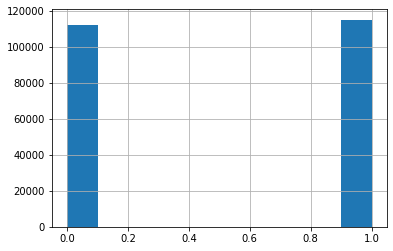

In [5]:
df['class'].hist()

In [6]:
df['class'].value_counts()

1    114911
0    111923
Name: class, dtype: int64

Clean text

In [7]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @ mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove rt (retweets)
    text = re.sub("rt", "", text)
    # Remove unneeded symbols
    text = re.sub(r"[/~/`/@/#/$/%/&/-/_/+/,/.]", "", text)
    # Remove extra spaces
    text = re.sub(" +", ' ', text)
    
    return text

In [8]:
tweet_tokenizer = TweetTokenizer()
X = []
y = []

for _, row in df.iterrows():
    txt = preprocess_text(row['text'])
    tokenized_text = ''
    try:
        tokenized_text = tweet_tokenizer.tokenize(txt)
    except:
        continue
    replaced_by_num = [fasttext.vocab[word].index for word in tokenized_text if word in fasttext.vocab]
    X.append(replaced_by_num)
    y.append(row['class'])

The longest sentence length

In [9]:
max([len(x) for x in X])

47

Divide data into the train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=42)

Embedding layer params

In [11]:
fasttext.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 507470,
 'output_dim': 300,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [12]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

BiLSTM model fitting

In [13]:
maxlen = 100
batch_size = 32

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(fasttext.get_keras_embedding())
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [EarlyStopping(monitor='val_f1', patience=1, min_delta=0.005),
             ModelCheckpoint(filepath='trained_models/fasttext_bilstm.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]
model.compile('adam', 'binary_crossentropy', metrics=[precision, recall, f1])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, 
                    validation_split=0.15, 
                    callbacks=callbacks)

X_train shape: (158783, 100)
X_test shape: (68051, 100)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 134965 samples, validate on 23818 samples
Epoch 1/10
134965/134965 [==============================] - 1411s 10ms/step - loss: 0.2249 - precision: 0.8865 - recall: 0.8836 - f1: 0.8801 - val_loss: 0.2005 - val_precision: 0.8774 - val_recall: 0.9253 - val_f1: 0.8977
Epoch 2/10
134965/134965 [==============================] - 2250s 17ms/step - loss: 0.1949 - precision: 0.9052 - recall: 0.8998 - f1: 0.8991 - val_loss: 0.1928 - val_precision: 0.9081 - val_recall: 0.9005 - val_f1: 0.9014


Fitting plots

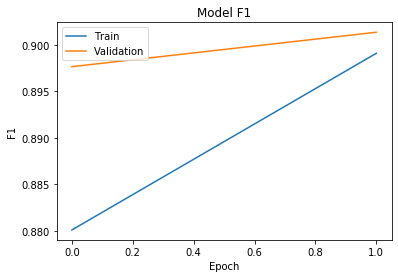

In [14]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

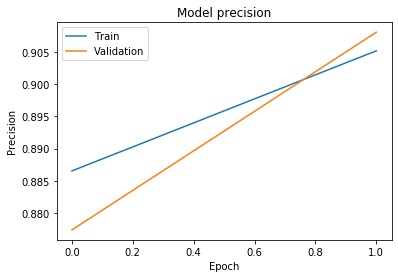

In [15]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

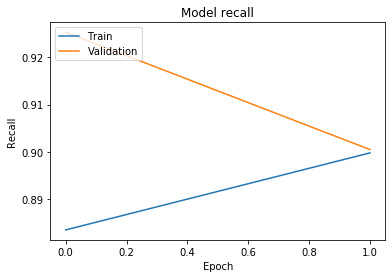

In [16]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

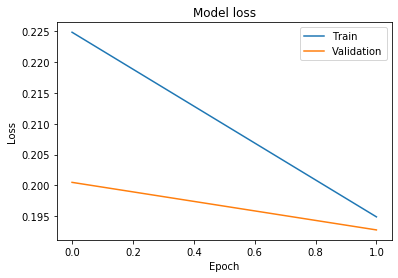

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test scores

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     33592
           1       0.90      0.90      0.90     34459

    accuracy                           0.90     68051
   macro avg       0.90      0.90      0.90     68051
weighted avg       0.90      0.90      0.90     68051



Concrete examples

In [19]:
def encode_text(text):
    preprocessed_text = preprocess_text(text)
    tokenized_text = tweet_tokenizer.tokenize(preprocessed_text)
    replaced_by_num = [fasttext.vocab[word].index for word in tokenized_text if word in fasttext.vocab]
    encoded = sequence.pad_sequences([replaced_by_num], maxlen=maxlen)
    
    return encoded

In [20]:
positive_without_smiles = "я так рад тебя видеть"
positive_with_smiles = "я так рад тебя видеть)"
positive_with_many_smiles = "я так рад тебя видеть)))"

print(positive_without_smiles, model.predict(encode_text(positive_without_smiles)))
print(positive_with_smiles, model.predict(encode_text(positive_with_smiles)))
print(positive_with_many_smiles, model.predict(encode_text(positive_with_many_smiles)))

я так рад тебя видеть [[0.6500975]]
я так рад тебя видеть) [[0.99972266]]
я так рад тебя видеть))) [[0.9999981]]


In [21]:
negative_without_smiles = "мы недовольны твоей работой. ты плохой работник"
negative_with_smiles = "мы недовольны твоей работой. ты плохой работник("
negative_with_many_smiles = "мы недовольны твоей работой. ты плохой работник((("

print(negative_without_smiles, model.predict(encode_text(negative_without_smiles)))
print(negative_with_smiles, model.predict(encode_text(negative_with_smiles)))
print(negative_with_many_smiles, model.predict(encode_text(negative_with_many_smiles)))

мы недовольны твоей работой. ты плохой работник [[0.35039848]]
мы недовольны твоей работой. ты плохой работник( [[8.55082e-05]]
мы недовольны твоей работой. ты плохой работник((( [[2.7726142e-07]]


In [22]:
neutral = "общее собрание состоится во вторник"
print(neutral, model.predict(encode_text(neutral)))

общее собрание состоится во вторник [[0.538129]]
